# III Prédiction et machine learning
Modèle de ML à utiliser:

**1 Regression linaire

**2 Regression Ridge

**3 Le Lasso

**4 ElasticNet

**5 SVM regression (sklearn.svm.LinearSVR)

**6 RandomForest regression

**7 Gradient Boosting


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import time
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [109]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 100)

Prépare la table des variables avec EmissionsCO2 à prédire

In [110]:
df = pd.read_csv("clean_building_data.csv") # on obtient la table avec ancien index comme nouvelle colonne
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [111]:
df.shape

(3414, 62)

In [112]:
df.fillna(0, inplace = True)

In [113]:
df.head()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,PrimaryPropertyType_Eductaion,PrimaryPropertyType_Health,PrimaryPropertyType_Hotel,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Storage,Neighborhood_Center,Neighborhood_East,Neighborhood_North,Neighborhood_South,Neighborhood_West,ZipCode_0.0,ZipCode_98101.0,ZipCode_98102.0,ZipCode_98103.0,ZipCode_98104.0,ZipCode_98105.0,ZipCode_98106.0,ZipCode_98107.0,ZipCode_98108.0,ZipCode_98109.0,ZipCode_98112.0,ZipCode_98115.0,ZipCode_98116.0,ZipCode_98117.0,ZipCode_98118.0,ZipCode_98119.0,ZipCode_98121.0,ZipCode_98122.0,ZipCode_98125.0,ZipCode_98126.0,ZipCode_98133.0,ZipCode_98134.0,ZipCode_98144.0,ZipCode_98199.0,SteamUse(kBtu)_percentage,Electricity(kBtu)_percentage,NaturalGas(kBtu)_percentage,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate
0,7,88,1.0,12.0,88434,0,88434,88434.0,0.0,65.0,78.9,173.5,22.735091,2023032.0,3686160.0,1272388.0,7.962491,2.64,47.612190,-122.337997,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.289767,0.527984,0.182249,1.000000,0.000000,0.000000
1,7,19,1.0,11.0,103566,15064,88502,83880.0,15064.0,51.0,94.4,191.3,22.994076,0.0,3905411.0,4448985.0,8.041714,2.38,47.613106,-122.333358,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.467468,0.532532,0.947775,0.170211,0.052225
2,7,46,1.0,41.0,961990,0,961990,757243.0,100000.0,18.0,96.6,242.7,26.123973,19660404.0,49762435.0,3709900.0,11.009465,1.92,47.613349,-122.337699,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.268832,0.680440,0.050728,0.787163,0.103951,0.000000
3,7,89,1.0,10.0,61320,0,61320,61320.0,0.0,1.0,460.4,636.3,24.750691,23458518.0,2769023.0,2001894.0,10.919117,31.38,47.614216,-122.336609,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.830995,0.098090,0.070915,1.000000,0.000000,0.000000
4,7,35,1.0,18.0,119890,12460,107430,123445.0,68009.0,67.0,120.1,228.8,23.821928,0.0,6066245.0,8763105.0,8.987832,4.02,47.613754,-122.340924,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000,0.409070,0.590930,1.149074,0.633054,0.000000


In [114]:
# valeurs NaN et valeurs infinit
def control_inf (df):
# suppression des lignes de valeurs infinis par les index
    indinf = df[np.isinf(df.values)==True].index
    df.drop(indinf, axis=0, inplace=True)
    print(df.shape)

In [115]:
control_inf(df)

(3394, 62)


In [116]:
df_emssion = df.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)',
                            'SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','GHGEmissionsIntensity','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)',
                            'ENERGYSTARScore']) # élimine la colonne cible, la colonne d'intensité d'émissionCO2 pour la table de prédiction CO2
                                                                                               # élimine la colonne 'energystarscore' pour l'évaluation de l'intérêt
df_energy = df.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)',
                            'SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','GHGEmissionsIntensity','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']) # élimine les mêmes colonnes d'EnergyUse pour la table de prédiction consommation totale d'énergy
                                                                                                                            # mais on garde energy score

In [117]:
df_emssion.head()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,Latitude,Longitude,PrimaryPropertyType_Eductaion,PrimaryPropertyType_Health,PrimaryPropertyType_Hotel,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Storage,Neighborhood_Center,Neighborhood_East,Neighborhood_North,Neighborhood_South,Neighborhood_West,ZipCode_0.0,ZipCode_98101.0,ZipCode_98102.0,ZipCode_98103.0,ZipCode_98104.0,ZipCode_98105.0,ZipCode_98106.0,ZipCode_98107.0,ZipCode_98108.0,ZipCode_98109.0,ZipCode_98112.0,ZipCode_98115.0,ZipCode_98116.0,ZipCode_98117.0,ZipCode_98118.0,ZipCode_98119.0,ZipCode_98121.0,ZipCode_98122.0,ZipCode_98125.0,ZipCode_98126.0,ZipCode_98133.0,ZipCode_98134.0,ZipCode_98144.0,ZipCode_98199.0,SteamUse(kBtu)_percentage,Electricity(kBtu)_percentage,NaturalGas(kBtu)_percentage,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate
0,7,88,1.0,12.0,88434,0,88434,88434.0,0.0,47.612190,-122.337997,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.289767,0.527984,0.182249,1.000000,0.000000,0.000000
1,7,19,1.0,11.0,103566,15064,88502,83880.0,15064.0,47.613106,-122.333358,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.467468,0.532532,0.947775,0.170211,0.052225
2,7,46,1.0,41.0,961990,0,961990,757243.0,100000.0,47.613349,-122.337699,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.268832,0.680440,0.050728,0.787163,0.103951,0.000000
3,7,89,1.0,10.0,61320,0,61320,61320.0,0.0,47.614216,-122.336609,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.830995,0.098090,0.070915,1.000000,0.000000,0.000000
4,7,35,1.0,18.0,119890,12460,107430,123445.0,68009.0,47.613754,-122.340924,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000,0.409070,0.590930,1.149074,0.633054,0.000000


In [118]:
df_emssion.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,Latitude,Longitude,PrimaryPropertyType_Eductaion,PrimaryPropertyType_Health,PrimaryPropertyType_Hotel,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Storage,Neighborhood_Center,Neighborhood_East,Neighborhood_North,Neighborhood_South,Neighborhood_West,ZipCode_0.0,ZipCode_98101.0,ZipCode_98102.0,ZipCode_98103.0,ZipCode_98104.0,ZipCode_98105.0,ZipCode_98106.0,ZipCode_98107.0,ZipCode_98108.0,ZipCode_98109.0,ZipCode_98112.0,ZipCode_98115.0,ZipCode_98116.0,ZipCode_98117.0,ZipCode_98118.0,ZipCode_98119.0,ZipCode_98121.0,ZipCode_98122.0,ZipCode_98125.0,ZipCode_98126.0,ZipCode_98133.0,ZipCode_98134.0,ZipCode_98144.0,ZipCode_98199.0,SteamUse(kBtu)_percentage,Electricity(kBtu)_percentage,NaturalGas(kBtu)_percentage,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate
count,3394.000000,3394.000000,3394.000000,3394.000000,3.394000e+03,3394.000000,3.394000e+03,3.394000e+03,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000,3394.000000
mean,4.370654,53.355333,1.114614,4.159988,1.160362e+05,13509.158810,1.025270e+05,9.312862e+04,18329.299145,47.616496,-122.332987,0.083382,0.027401,0.048615,0.273718,0.248674,0.007071,0.208014,0.119623,0.165881,0.203889,0.296995,0.203300,0.019446,0.090454,0.017089,0.041249,0.096641,0.052445,0.015910,0.030053,0.070418,0.084856,0.012964,0.031232,0.015616,0.011196,0.028285,0.040071,0.048026,0.053919,0.035062,0.014732,0.030937,0.112257,0.029758,0.012669,0.020889,0.699209,0.277249,0.917514,0.147680,0.026112
std,2.192861,32.864185,2.195057,6.519917,2.484969e+05,43519.335424,2.311860e+05,2.232782e+05,50134.025059,0.048287,0.024703,0.276500,0.163274,0.215094,0.445932,0.432308,0.083806,0.405947,0.324568,0.372029,0.402947,0.457002,0.402513,0.138107,0.286873,0.129622,0.198895,0.295512,0.222957,0.125148,0.170758,0.255889,0.278708,0.113136,0.173969,0.124002,0.105234,0.165811,0.196154,0.213853,0.225890,0.183963,0.120495,0.173172,0.315729,0.169945,0.111860,0.090680,0.261722,0.261147,0.393076,0.227168,0.074214
min,1.000000,1.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,0.000000e+00,0.000000,47.499170,-122.411820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,26.000000,1.000000,1.000000,2.979600e+04,0.000000,2.858600e+04,2.453700e+04,0.000000,47.585957,-122.343700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.494993,0.000000,0.784122,0.000000,0.000000
50%,4.000000,50.000000,1.000000,2.000000,4.976000e+04,0.000000,4.768600e+04,4.236700e+04,0.000000,47.612508,-122.333000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [119]:
print(df_emssion.shape)
print(df_energy.shape)
print(df.shape)

(3394, 53)
(3394, 54)
(3394, 62)


In [120]:
print("Emplacement variable EmissionCO2 :[TotalGHGEmissions] 15")
print("Emplacement variable Consommation totale d\'énergie: [SiteEnergyUse(kBtu)] 11")
print("Emplacement variable EnergyStar score: [ENERGYSTARScore] 8 ")

Emplacement variable EmissionCO2 :[TotalGHGEmissions] 15
Emplacement variable Consommation totale d'énergie: [SiteEnergyUse(kBtu)] 11
Emplacement variable EnergyStar score: [ENERGYSTARScore] 8 


In [121]:
print("On obtient deux tables sans valeurs infinies.")

On obtient deux tables sans valeurs infinies.


In [122]:
df.columns

Index(['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Latitude', 'Longitude',
       'PrimaryPropertyType_Eductaion', 'PrimaryPropertyType_Health',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Storage', 'Neighborhood_Center',
       'Neighborhood_East', 'Neighborhood_North', 'Neighborhood_South',
       'Neighborhood_West', 'ZipCode_0.0', 'ZipCode_98101.0',
       'ZipCode_98102.0', 'ZipCode_98103.0', 'ZipCode_98104.0',
       'ZipCode_98105.0', 'ZipCode_98106.0', 'ZipCode_98107.0',
 

In [123]:
# Créer une table vide afin de stocker toutes les resultats de modèles
df_score = pd.DataFrame(columns=['Modèle', 'MSE', 'R²', 'Time'],index=None)
df_score

,Modèle,MSE,R²,Time


**3.1.1  La baseline : régression linéaire**

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [125]:
# récupérer les values dans la table de composants principals
X = df_emssion.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [126]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [127]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, random_state=42, test_size=0.2)

In [128]:
start_time = time.time()
lr = LinearRegression().fit(X_train, y_train)
# prédire l'émission de X_test
y_pred = lr.predict(X_test)
train_time = time.time() - start_time
lr_mse_co2 = mean_squared_error(y_test, y_pred)
# évaluer le modèle par le coefficient de détermination r²
lr_r2_co2 = r2_score(y_test, y_pred)
print('[Modèle linéaire prédiction d\'émission CO2] \nMSE {:.2f} \nR² {:.2f}\nTime {:.2f}s'.format(lr_mse_co2, lr_r2_co2, train_time))

[Modèle linéaire prédiction d'émission CO2] 
MSE 5.84 
R² -0.14
Time 0.01s


In [129]:
import statsmodels.api as stats
from statsmodels.tools import add_constant
# AIC linéaire
lr = stats.OLS(add_constant(X_std), y).fit()
aic_linear = lr.aic
print(aic_linear)

23104.685574460258


In [130]:
# Ajoute la performance du modèle linéaire dans la table de résultat
df_score = df_score.append(pd.DataFrame({'Modèle':'RegressionLinéaire', 'MSE': [lr_mse_co2], 'R²': [lr_r2_co2], 'Time': [train_time]}, index=None))

In [131]:
# Check la table de résultat
df_score

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.84185,-0.141096,0.014949


**3.2.1 Regression Ridge GHGEmissions**

In [132]:
from sklearn.linear_model import Ridge

In [133]:
# récupérer les values dans la table de composants principals
X = df_emssion.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [134]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.2)

In [135]:
# définir la grille des valeur d'hyperparamètre
lamdas = np.logspace(start=-5,stop=5,num=10, base=10)
# stocker tout les coefficients de régularisation 
coefs_ridge_co2 = []
# stocker les valeurs d'erreurs
errors_ridge_co2 = []
# stocker les valeurs de score (r²)
score_ridge_co2 = []
# stocker le temps d'entrainement
time_ridge = []
# définir dataframe pour stocker les résultats en fonction de alpha
result_ridge = pd.DataFrame(columns=['alpha', 'MSE', 'R²', 'Time'],index=None)
ridge = Ridge()
for a in lamdas:
    ridge.set_params(alpha=a) # tester divers valeurs d'hyperparamètre de manière manuelle au lieu d'utiliser GridSearchCV()
    start_time = time.time()
    ridge.fit(X_train, y_train) # fit modèle avec X_train, y_train
    y_pred= ridge.predict(X_test)
    train_time = time.time() - start_time
    time_ridge = train_time
    coefs_ridge_co2 = ridge.coef_ # liste des coefficients restraignant l'amplitude des poids de varaibles
    errors_ridge_co2 = mean_squared_error(ridge.predict(X_test), y_test) # calcule MSE ridge
    score_ridge_co2 = r2_score(ridge.predict(X_test), y_test)
    result_ridge = result_ridge.append(pd.DataFrame({'alpha':[a], 'MSE':[errors_ridge_co2], 'R²':[score_ridge_co2], 'Time': [time_ridge]},
                index=None))

In [136]:
result_ridge = result_ridge.sort_values(by='R²', ascending= False).reset_index()

In [137]:
result_ridge

,index,alpha,MSE,R²,Time
0,0,0.000010,2.224034,0.185394,0.005936
1,0,0.000129,2.224034,0.185394,0.004984
2,0,0.001668,2.224033,0.185392,0.002992
3,0,0.021544,2.224027,0.185365,0.003964
4,0,0.278256,2.223944,0.185031,0.005980
5,0,3.593814,2.223207,0.181366,0.003986
6,0,46.415888,2.217646,0.158328,0.005008
7,0,599.484250,2.243100,-0.075954,0.002989
8,0,7742.636827,3.103903,-5.131009,0.002993
9,0,100000.000000,4.550117,-370.014754,0.004982


c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='TotalGHGEmissions'>

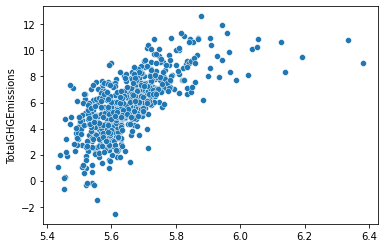

In [138]:
sns.scatterplot(y_pred, y_test)

In [139]:
ridge_mse_co2 = result_ridge['MSE'][0]
ridge_r2_co2 = result_ridge['R²'][0]
time_ridge = result_ridge['Time'][0]

In [140]:
df_score = df_score.append(pd.DataFrame({'Modèle':'RegressionRidge', 'MSE': [ridge_mse_co2], 'R²': [ridge_r2_co2], 'Time': [time_ridge]}, index=None))
df_score

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.841850,-0.141096,0.014949
0,RegressionRidge,2.224034,0.185394,0.005936


**3.3.1 Regression le Lasso GHGEmissions**

In [141]:
from sklearn.linear_model import Lasso

In [142]:
# récupérer les values dans la table de composants principals
X = df_emssion.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [143]:
# standardiser les variables
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.2)
# effectuer une recherche des hyperparamètres de manière automatisée

alphas = np.logspace(start=-5,stop=5,num=10, base=10)
lasso = Lasso()
coefs_lasso_co2 = []
errors_lasso_co2 = []
score_lasso_co2 = []
train_time = []
result_lasso = pd.DataFrame(columns=['alpha', 'MSE', 'R²', 'Time'], index=None)
for a in alphas:
    lasso.set_params(alpha=a)
    start_time = time.time()
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    train_time = time.time() - start_time
    coefs_lasso_co2 = lasso.coef_
    errors_lasso_co2= mean_squared_error(y_pred, y_test)
    score_lasso_co2 = r2_score(y_pred, y_test)
    result_lasso = result_lasso.append(pd.DataFrame({'alpha':[a], 'MSE':[errors_lasso_co2], 'R²':[score_lasso_co2], 'Time': [train_time]},
                index=None))

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.526e+00, tolerance: 1.333e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.843e+00, tolerance: 1.333e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

In [144]:
result_lasso = result_lasso.sort_values(by='R²', ascending= False).reset_index()

In [145]:
result_lasso

,index,alpha,MSE,R²,Time
0,0,0.000010,2.042625,3.562401e-01,0.105699
1,0,0.000129,2.041817,3.556408e-01,0.101103
2,0,0.001668,2.038006,3.481974e-01,0.064317
3,0,0.021544,2.045155,2.752885e-01,0.017940
4,0,0.278256,2.698885,-1.563100e+00,0.004023
5,0,3.593814,4.904956,-6.217771e+30,0.004055
6,0,46.415888,4.904956,-6.217771e+30,0.003939
7,0,599.484250,4.904956,-6.217771e+30,0.005046
8,0,7742.636827,4.904956,-6.217771e+30,0.004020
9,0,100000.000000,4.904956,-6.217771e+30,0.002931


In [146]:
lasso_mse_co2 = result_lasso['MSE'][0]
lasso_r2_co2 = result_lasso['R²'][0]
time_lasso = result_lasso['Time'][0]

In [147]:
df_score = df_score.append(pd.DataFrame({'Modèle':'RegressionLasso', 'MSE': [lasso_mse_co2], 'R²': [lasso_r2_co2], 'Time': [time_lasso]}, index=None))

In [148]:
df_score

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.841850,-0.141096,0.014949
0,RegressionRidge,2.224034,0.185394,0.005936
0,RegressionLasso,2.042625,0.356240,0.105699


In [149]:
print("Evaluer la performance  par AIC")

Evaluer la performance  par AIC


In [150]:
from sklearn.linear_model import LassoLarsIC
# AIC lasso
lasso_lars_ic = LassoLarsIC(criterion="aic", normalize=False).fit(X_std, y)
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic.alphas_,
        "AIC criterion": lasso_lars_ic.criterion_
    }
).set_index("alphas")

In [151]:
results.sort_values(by='AIC criterion',ascending=True).head()

,AIC criterion
alphas,
0.003698,1431.080756
0.003860,1431.316040
0.002405,1431.466633
0.003871,1433.333040
0.002356,1433.416062


In [152]:
aic_lasso = results['AIC criterion'].min()
print(aic_lasso)

1431.0807557407575


**3.4.1 ElasticNet (GHGEmissions)**

In [153]:
from sklearn.linear_model import ElasticNet

In [154]:
# récupérer les values dans la table de composants principals
X = df_emssion.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [155]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, random_state=42, test_size=0.2)

In [156]:

alphas = np.logspace(start=-5,stop=5,num=10, base=10)
elas_reg = ElasticNet()
coefs_elas = []
errors_elas = []
score_elas = []
train_time=[]
result_EN = pd.DataFrame(columns=['alpha', 'MSE', 'R²', 'Time'], index=None)
for a in alphas:
    elas_reg.set_params(alpha=a)
    start_time = time.time()
    elas_reg.fit(X_train, y_train)
    y_pred = elas_reg.predict(X_test)
    train_time = time.time() - start_time
    coefs_elas=elas_reg.coef_
    errors_elas= mean_squared_error(elas_reg.predict(X_test), y_test)
    score_elas= r2_score(elas_reg.predict(X_test), y_test)
    result_EN = result_EN.append(pd.DataFrame({'alpha':[a], 'MSE':[errors_elas], 'R²':[score_elas], 'Time': [train_time]},
                index=None))

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.562e+02, tolerance: 1.318e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.734e+02, tolerance: 1.318e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

In [157]:
result_EN = result_EN.sort_values(by='R²', ascending= False).reset_index(drop=True)

In [158]:
result_EN

,alpha,MSE,R²,Time
0,0.021544,4.982256,2.881170e-01,0.014646
1,0.001668,5.770054,2.844134e-01,0.095737
2,0.000129,5.832895,2.842835e-01,0.124870
3,0.000010,5.837800,2.842583e-01,0.122039
4,0.278256,3.559342,2.817032e-03,0.003976
5,3.593814,5.120748,-1.622830e+30,0.003018
6,46.415888,5.120748,-1.622830e+30,0.005936
7,599.484250,5.120748,-1.622830e+30,0.007969
8,7742.636827,5.120748,-1.622830e+30,0.005861
9,100000.000000,5.120748,-1.622830e+30,0.002992


In [159]:
elas_mse_co2 = result_EN['MSE'][0]
elas_r2_co2 = result_EN['R²'][0]
time_elas = result_EN['Time'][0]
df_score = df_score.append(pd.DataFrame({'Modèle':'RegressionElasticNet', 'MSE': [elas_mse_co2], 'R²': [elas_r2_co2], 'Time': [time_elas]}, index=None))

In [160]:
df_score

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.841850,-0.141096,0.014949
0,RegressionRidge,2.224034,0.185394,0.005936
0,RegressionLasso,2.042625,0.356240,0.105699
0,RegressionElasticNet,4.982256,0.288117,0.014646


**3.5.1 SVM Linaire / à noyau (GHGEmissions)**

In [161]:
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

In [162]:
# récupérer les values dans la table de composants principals
X = df_emssion.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [163]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.2)

In [164]:
params =  np.logspace(start=-5,stop=5, num=7, base= 10)

In [165]:
params

array([1.00000000e-05, 4.64158883e-04, 2.15443469e-02, 1.00000000e+00,
       4.64158883e+01, 2.15443469e+03, 1.00000000e+05])

In [166]:
svr = SVR()
param_grid = {'epsilon': params,'C':[0.1, 1, 10],'kernel': ["linear", "rbf", "sigmoid", "poly"]}
svr = GridSearchCV(svr,
                      param_grid, 
                      cv=5,
                      scoring='r2',
                      return_train_score=True)
# fit le modèle svr avec training data
svr.fit(X_train, y_train)
y_pred= svr.predict(X_test)

In [167]:
result_svr = pd.DataFrame(columns=['C', 'epsilon','kernel','R²_train','R²_test', 'Time'], index=None)
# Afficher les performances correspendantes
print("Résultat de la validation croisée:")
for c, epsilon, score_0, score_1, kernel, temps in zip(
    svr.cv_results_['param_C'],
    svr.cv_results_['param_epsilon'],
    svr.cv_results_['mean_train_score'], # score du jeu de X_test
    svr.cv_results_['mean_test_score'], # score du jeu de y_test
    
    svr.cv_results_['param_kernel'],
    svr.cv_results_['mean_fit_time']
):
    result_svr = result_svr.append(pd.DataFrame({'C':[c], 'epsilon':[epsilon], 'kernel':[kernel],'R²_train':[score_0],'R²_test':[score_1], 'Time': [temps]},
                index=None))
result_svr = result_svr.sort_values(by='R²_test', ascending=False).reset_index(drop=True)
result_svr.head(20)

Résultat de la validation croisée:


,C,epsilon,kernel,R²_train,R²_test,Time
0,10.0,0.021544,rbf,0.869996,0.737136,0.844791
1,10.0,0.000464,rbf,0.869543,0.736363,0.952417
2,10.0,0.000010,rbf,0.869534,0.736346,0.951025
3,10.0,1.000000,rbf,0.829362,0.723990,0.265017
4,1.0,0.021544,rbf,0.745453,0.679348,0.445504
5,1.0,0.000464,rbf,0.745258,0.679254,0.464486
6,1.0,0.000010,rbf,0.745255,0.679248,0.492650
7,1.0,1.000000,rbf,0.711938,0.652733,0.205996
8,0.1,0.000010,rbf,0.492014,0.470037,0.413820
9,0.1,0.000464,rbf,0.492017,0.470034,0.387762


In [168]:
svr.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_epsilon', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [169]:
# Afficher la meilleur paramètre C pour le modèle
print('Meilleur hyperparamètre sur le jeu d\'entrainement: ')
print(svr.best_params_)
print("Avec le best score (SVR):")
best_score = svr.best_score_
print(svr.best_score_)

Meilleur hyperparamètre sur le jeu d'entrainement: 
{'C': 10, 'epsilon': 0.021544346900318846, 'kernel': 'rbf'}
Avec le best score (SVR):
0.7371360516233884


In [170]:
# visualier la performance fit modèle sur le jeu d'entrainement et le jeu de test
result_svr_c = result_svr.iloc[:,np.r_[0,3,4]]
result_svr_ep = result_svr.iloc[:,np.r_[1,3,4]]
result_svr_k = result_svr.iloc[:,np.r_[2,3,4]]

In [171]:
# calcul des métriques
svr_mse_co2 = mean_squared_error(y_pred, y_test)
svr_r2_co2 = r2_score(y_pred, y_test)
print(svr_mse_co2, svr_r2_co2)

1.3313219635311577 0.611346612297615


In [172]:
df_score = df_score.append(pd.DataFrame({'Modèle':'SVM à noyau', 'MSE': [svr_mse_co2], 'R²': [svr_r2_co2], 'Time': [temps]}, index=None))
df_score

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.841850,-0.141096,0.014949
0,RegressionRidge,2.224034,0.185394,0.005936
0,RegressionLasso,2.042625,0.356240,0.105699
0,RegressionElasticNet,4.982256,0.288117,0.014646
0,SVM à noyau,1.331322,0.611347,0.001205


**3.6.1 Random Forest - regression (GHGEmissions)**

In [173]:
from sklearn.ensemble import RandomForestRegressor
#from sklearn.feature_selection import SelectFromModel

In [174]:
# récupérer les values dans la table de composants principals
X = df_emssion.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [175]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [176]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.2)

In [177]:
params_grid = {'n_estimators': [700, 900],'max_features':['sqrt', 'log2'],'max_depth':[1, 5, 10], 'max_samples':[0.5, 0.7], 'min_samples_split':[1, 2],
                    'max_leaf_nodes': [None, 5, 10]} # fourchette des valeurs de l'hyperparamètre m

rfr = GridSearchCV(RandomForestRegressor(), # n_estimator = nombre d'arbre
                   params_grid,
                   cv=5,
                   scoring='r2',
                   return_train_score=True
                   )
# fit le modèle regression avec le jeu d'entrainement
rfr_model = rfr.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)

print(rfr_model.best_estimator_)
rfr_mse_co2 = mean_squared_error(y_pred, y_test)
rfr_r2_co2 = r2_score(y_pred, y_test)

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\ensemble\_forest.py", line 441, in fit
    trees = Parallel(
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch

RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.7,
                      n_estimators=900)


In [178]:
rfr_model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_max_leaf_nodes', 'param_max_samples', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [179]:
result_rfr = pd.DataFrame(columns=['n_estimators','max_depth','max_features','max_samples','min_samples_split', 'max_leaf_nodes', 'R²_train','R²_test' ,'Time'], index=None)
# Afficher les performances correspendantes dans la validation croisée
print("Résultat de la validation croisée:")
for est, dep, feat, sam, split, node, score_0, score_1, temps in zip(
    rfr_model.cv_results_['param_n_estimators'],
    rfr_model.cv_results_['param_max_depth'],
    rfr_model.cv_results_['param_max_features'],
    rfr_model.cv_results_['param_max_samples'],
    rfr_model.cv_results_['param_min_samples_split'],
    rfr_model.cv_results_['param_max_leaf_nodes'],
    rfr_model.cv_results_['mean_train_score'],
    rfr_model.cv_results_['mean_test_score'], # score moyenne du jeu de test
    rfr_model.cv_results_['mean_fit_time']
):
    result_rfr = result_rfr.append(pd.DataFrame({'n_estimators':[est], 'max_depth':[dep],'max_features':[feat],'max_samples':[sam],'min_samples_split':[split],'max_leaf_nodes':[node], 'R²_train':[score_0],'R²_test':[score_1], 'Time': [temps]},
                index=None))
result_rfr = result_rfr.sort_values(by='R²_test', ascending=False)
result_rfr.head()

Résultat de la validation croisée:


,n_estimators,max_depth,max_features,max_samples,min_samples_split,max_leaf_nodes,R²_train,R²_test,Time
0,900,10,sqrt,0.7,2,None,0.879488,0.787367,1.992236
0,700,10,sqrt,0.7,2,None,0.879733,0.787069,1.564735
0,700,10,sqrt,0.5,2,None,0.865166,0.778822,1.360525
0,900,10,sqrt,0.5,2,None,0.864969,0.778719,1.740428
0,700,10,log2,0.7,2,None,0.855088,0.765937,1.371980


In [180]:
df_score = df_score.append(pd.DataFrame({'Modèle':'Random Forest', 'MSE': [rfr_mse_co2], 'R²': [rfr_r2_co2], 'Time': [temps]}, index=None))
df_score

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.841850,-0.141096,0.014949
0,RegressionRidge,2.224034,0.185394,0.005936
0,RegressionLasso,2.042625,0.356240,0.105699
0,RegressionElasticNet,4.982256,0.288117,0.014646
0,SVM à noyau,1.331322,0.611347,0.001205
0,Random Forest,1.019798,0.618141,1.190569


In [181]:
print(rfr_mse_co2, rfr_r2_co2)

1.0197977022568003 0.6181408504346142


**3.6.2 RandomForest bagging**

In [182]:
from sklearn.ensemble import BaggingRegressor

In [183]:
# récupérer les values dans la table de composants principals
X = df_emssion.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [184]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [185]:
X_train, X_test, y_train, y_test_bag = model_selection.train_test_split(X_std, y, test_size=0.2)

In [186]:
# introduire méthode bagging et voir la performance du modèle rfr
bagging = BaggingRegressor(n_estimators=5)
bagging.fit(X_train, y_train)

BaggingRegressor(n_estimators=5)

In [187]:
params_grid = {'n_estimators': [700, 900], 'max_features':['sqrt', 'log2'],'max_depth':[1, 5, 10], 'max_samples':[0.5, 0.7], 'min_samples_split':[1, 2]} # fourchette des valeurs de l'hyperparamètre m

rfr_bagging = GridSearchCV(RandomForestRegressor(), # n_estimator = nombre d'arbre
                   params_grid,
                   cv=5,
                   scoring='r2',
                   return_train_score=True,
                   refit=True)
# fit le modèle regression avec le jeu d'entrainement
rfr_model_bagging = rfr_bagging.fit(X_train, y_train)
y_pred_bag = rfr_model_bagging.predict(X_test)

print(rfr_model_bagging.best_estimator_)

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\ensemble\_forest.py", line 441, in fit
    trees = Parallel(
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch

RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.7,
                      n_estimators=900)


In [188]:
result_rfr_bagging = pd.DataFrame(columns=['n_estimators','max_depth','max_features','max_samples','min_samples_split', 'R²_train','R²_test' ,'Time'], index=None)
# Afficher les performances correspendantes dans la validation croisée
print("Résultat de la validation croisée:")
for est, dep, feat, sam, split, score_0, score_1, temps in zip(
    rfr_model_bagging.cv_results_['param_n_estimators'],
    rfr_model_bagging.cv_results_['param_max_depth'],
    rfr_model_bagging.cv_results_['param_max_features'],
    rfr_model_bagging.cv_results_['param_max_samples'],
    rfr_model_bagging.cv_results_['param_min_samples_split'],
    rfr_model_bagging.cv_results_['mean_train_score'],
    rfr_model_bagging.cv_results_['mean_test_score'], # score moyenne du jeu de test
    rfr_model_bagging.cv_results_['mean_fit_time']
):
    result_rfr_bagging = result_rfr_bagging.append(pd.DataFrame({'n_estimators':[est], 'max_depth':[dep],'max_features':[feat],'max_samples':[sam],'min_samples_split':[split],'R²_train':[score_0],'R²_test':[score_1], 'Time': [temps]},
                index=None))
result_rfr_bagging = result_rfr_bagging.sort_values(by='R²_test', ascending=False).reset_index(drop=True)
result_rfr_bagging.head(20)

Résultat de la validation croisée:


,n_estimators,max_depth,max_features,max_samples,min_samples_split,R²_train,R²_test,Time
0,900,10,sqrt,0.7,2,0.877314,0.785176,2.023232
1,700,10,sqrt,0.7,2,0.877027,0.785113,1.558398
2,900,10,sqrt,0.5,2,0.862996,0.778919,1.726689
3,700,10,sqrt,0.5,2,0.862423,0.777164,1.322800
4,900,10,log2,0.7,2,0.852314,0.764706,1.696483
5,700,10,log2,0.7,2,0.852583,0.764181,1.304000
6,700,10,log2,0.5,2,0.839941,0.758779,1.151725
7,900,10,log2,0.5,2,0.839487,0.757538,1.489390
8,700,5,sqrt,0.7,2,0.705496,0.671929,1.039414
9,900,5,sqrt,0.7,2,0.705194,0.671516,1.355684


In [189]:
rfr_mse_bag = mean_squared_error(y_pred_bag, y_test_bag)
rfr_r2_bag = r2_score(y_pred_bag, y_test_bag)
print(rfr_mse_bag, rfr_r2_bag)

1.0527177342154381 0.6365973921785826


In [190]:
print("Modèle RF est loin d\'être performant. Nous allons sélectionner les features importantes.")

Modèle RF est loin d'être performant. Nous allons sélectionner les features importantes.


Sélection features random forest bagging

In [191]:
rfr_model_bagging.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.7,
                      n_estimators=900)

In [192]:
rfr_cv = RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.7, min_samples_split=2,
                      n_estimators=900)
rfr_cv.fit(X_train, y_train)
y_pred_cv = rfr_cv.predict(X_test)

In [193]:
from sklearn.feature_selection import SelectFromModel

In [194]:
threshold=[0.0001, 0.003, 0.025, 0.075, 0.1]
for thre in threshold:
    select = SelectFromModel(rfr_cv, prefit=True, threshold=thre)
    print(select)
    # nouvelle training data après la sélection de features
    X_train_se = select.transform(X_train)
    print(X_train_se.shape)
    X_test_se = select.transform(X_test)
    print(X_test_se.shape)
    # appliquer le modèle entrainé avec meilleur hyperparametre sur les nouvelle split
    start_time = time.time()
    rfr_cv_se = RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.7, min_samples_split=2,
                        n_estimators=900)
    rfr_cv_se.fit(X_train_se, y_train)   
    y_pred_cvse = rfr_cv_se.predict(X_test_se)
    temps_se = time.time() - start_time
    rfr_r2_se = r2_score(y_pred_cvse, y_test_bag)
    rfr_mse_se = mean_squared_error(y_pred_cvse, y_test_bag)
    print(thre, rfr_r2_se, rfr_mse_se, temps_se)   


SelectFromModel(estimator=RandomForestRegressor(max_depth=10,
                                                max_features='sqrt',
                                                max_samples=0.7,
                                                n_estimators=900),
                prefit=True, threshold=0.0001)
(2715, 53)
(679, 53)
0.0001 0.6331198160251312 1.0552554885536467 2.7026851177215576
SelectFromModel(estimator=RandomForestRegressor(max_depth=10,
                                                max_features='sqrt',
                                                max_samples=0.7,
                                                n_estimators=900),
                prefit=True, threshold=0.003)
(2715, 23)
(679, 23)
0.003 0.6892127869366867 0.9773202154352251 2.9199001789093018
SelectFromModel(estimator=RandomForestRegressor(max_depth=10,
                                                max_features='sqrt',
                                                max_samples=0.7,
                

In [195]:
df_score = df_score.append(pd.DataFrame({'Modèle':'Random Forest avec bagging', 'MSE': [rfr_mse_bag], 'R²': [rfr_r2_bag], 'Time': [temps]}, index=None))
df_score

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.841850,-0.141096,0.014949
0,RegressionRidge,2.224034,0.185394,0.005936
0,RegressionLasso,2.042625,0.356240,0.105699
0,RegressionElasticNet,4.982256,0.288117,0.014646
0,SVM à noyau,1.331322,0.611347,0.001205
0,Random Forest,1.019798,0.618141,1.190569
0,Random Forest avec bagging,1.052718,0.636597,1.696483


Random forest feature importance

In [196]:
#df_importance =pd.DataFrame({'features': X_train.columns, }) rfr_model_bagging.best_estimator_.feature_importances_
#feature_name = rfr_model_bagging.best_estimator_.feature_names_in_
#df_coefficient = pd.DataFrame(feature_importance, index=rfr_model_bagging.columns, columns=['importance']).sort_values('importance', ascending=False)

In [197]:
#sklearn.__version__

In [198]:
#pd.DataFrame(feature_importance, columns=rfr_model_bagging.best_estimator_.index)

**3.7.1 Gradient Boosting**

In [199]:
from sklearn.ensemble import GradientBoostingRegressor

In [200]:
# récupérer les values dans la table de composants principals
X = df_emssion.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [201]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [202]:
X_train, X_test, y_train, y_test_xg0 = model_selection.train_test_split(X_std, y, random_state=42, test_size=0.2)

In [203]:
# introduire méthode bagging et voir la performance du modèle rfr
bagging = BaggingRegressor(n_estimators=5)
bagging.fit(X_train, y_train)

BaggingRegressor(n_estimators=5)

In [204]:
params_grid = {'n_estimators': [500, 700, 900], 'learning_rate':[0.1, 0.2, 0.3, 0.5],'max_depth':[1, 2, 3]} # fourchette des valeurs de l'hyperparamètre m

xgboost = GridSearchCV(GradientBoostingRegressor(), # n_estimator = nombre d'arbre
                   params_grid,
                   cv=5,
                   scoring='r2',
                   return_train_score=True)
# fit le modèle regression avec le jeu d'entrainement
xgboost_bagging = xgboost.fit(X_train, y_train)
y_pred_xg0 = xgboost_bagging.predict(X_test)

print(xgboost_bagging.best_estimator_)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=900)


In [205]:
xgboost.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [206]:
result_xgboost = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'Time'], index=None)
# Afficher les performances correspendantes dans la validation croisée
print("Résultat de la validation croisée:")
for rate, dep, est, score_0, score_1, temps in zip(
    xgboost_bagging.cv_results_['param_learning_rate'],
    xgboost_bagging.cv_results_['param_max_depth'],
    xgboost_bagging.cv_results_['param_n_estimators'],
    xgboost_bagging.cv_results_['mean_train_score'],
    xgboost_bagging.cv_results_['mean_test_score'], # score moyenne du jeu de test
    xgboost_bagging.cv_results_['mean_fit_time']
):
    result_xgboost = result_xgboost.append(pd.DataFrame({'n_estimators':[est], 'learning_rate':[rate],'max_depth':[dep],'R²_train':[score_0], 'R²_test':[score_1], 'Time': [temps]},
                index=None))
result_xgboost = result_xgboost.sort_values(by='R²_test', ascending=False).reset_index(drop=True)
result_xgboost.head(20)

Résultat de la validation croisée:


,n_estimators,learning_rate,max_depth,Time,R²_train,R²_test
0,900,0.2,3,5.692384,0.994271,0.849210
1,900,0.3,3,6.747154,0.998347,0.847677
2,700,0.3,3,4.407887,0.996401,0.846970
3,700,0.2,3,4.446286,0.989526,0.846507
4,500,0.3,3,3.161932,0.991375,0.844688
5,900,0.1,3,5.799677,0.974885,0.843422
6,500,0.2,3,3.229847,0.979555,0.842441
7,700,0.1,3,4.441078,0.963706,0.838639
8,500,0.1,3,3.729506,0.946027,0.832588
9,900,0.2,2,3.911800,0.958250,0.825222


In [207]:
xgboost_mse_co2 = mean_squared_error(y_pred_xg0, y_test_xg0)
xgboost_r2_co2 = r2_score(y_pred_xg0, y_test_xg0)

In [208]:
df_score = df_score.append(pd.DataFrame({'Modèle':'GradientBoosting avec bagging', 'MSE': [xgboost_mse_co2], 'R²': [xgboost_r2_co2], 'Time': [temps]}, index=None))
df_score

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.841850,-0.141096,0.014949
0,RegressionRidge,2.224034,0.185394,0.005936
0,RegressionLasso,2.042625,0.356240,0.105699
0,RegressionElasticNet,4.982256,0.288117,0.014646
0,SVM à noyau,1.331322,0.611347,0.001205
0,Random Forest,1.019798,0.618141,1.190569
0,Random Forest avec bagging,1.052718,0.636597,1.696483
0,GradientBoosting avec bagging,0.654774,0.845108,6.678702


**3.9.1 Résumé performances sur différents modèles (prédiction EmissionsCO2)**

In [209]:
print("Baseline regression linéaire: MSE {:.3f}, R² score {:.3f}, AIC {:.3f}".format(lr_mse_co2, lr_r2_co2, aic_linear))
print("Regression ridge: MSE {:.3f}, R² score {:.3f}".format(ridge_mse_co2, ridge_r2_co2))
print("Regression lasso: MSE {:.3f}, R² score {:.3f}, AIC {:.3f}".format(lasso_mse_co2, lasso_r2_co2, aic_lasso))
print("Regression ElasticNet: MSE {:.3f}, R² score {:.3f}".format(elas_mse_co2, elas_r2_co2))
print("Regression SVM: MSE {:.3f}, R² score {:.3f}".format(svr_mse_co2, svr_r2_co2))
print("Regression random forest: MSE {:.3f}, R² score {:.3f}".format(rfr_mse_co2, rfr_r2_co2))

Baseline regression linéaire: MSE 5.842, R² score -0.141, AIC 23104.686
Regression ridge: MSE 2.224, R² score 0.185
Regression lasso: MSE 2.043, R² score 0.356, AIC 1431.081
Regression ElasticNet: MSE 4.982, R² score 0.288
Regression SVM: MSE 1.331, R² score 0.611
Regression random forest: MSE 1.020, R² score 0.618


**3.9.2 Visualisation du résultat de performance (EmissionsCO2)**

In [210]:
df_score.reset_index().drop(columns='index')

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.841850,-0.141096,0.014949
1,RegressionRidge,2.224034,0.185394,0.005936
2,RegressionLasso,2.042625,0.356240,0.105699
3,RegressionElasticNet,4.982256,0.288117,0.014646
4,SVM à noyau,1.331322,0.611347,0.001205
5,Random Forest,1.019798,0.618141,1.190569
6,Random Forest avec bagging,1.052718,0.636597,1.696483
7,GradientBoosting avec bagging,0.654774,0.845108,6.678702


In [211]:
# On élimine le modèle linéaire regression de cette présentation car hors normes
df_score_compare = df_score[df_score['Modèle'] != 'RegressionLinéaire'].set_index('Modèle')
x = np.arange(len(df_score_compare.index))

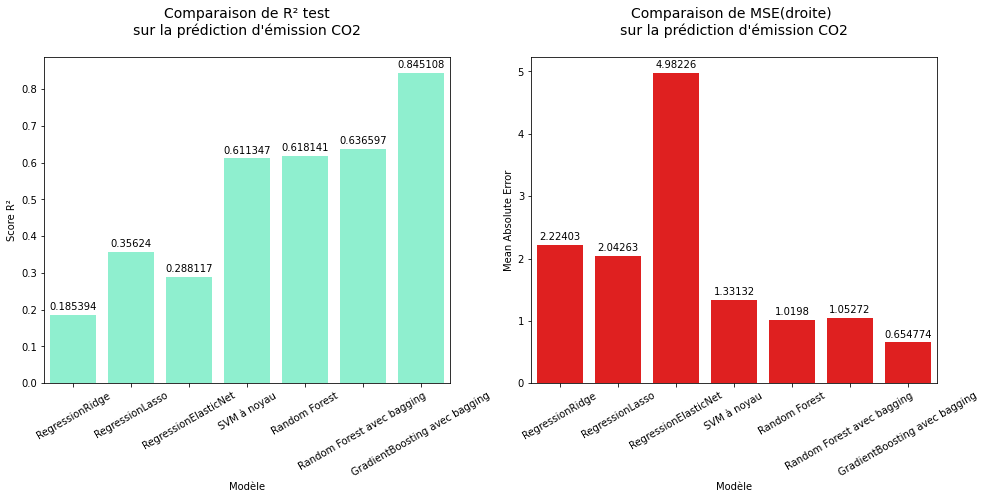

In [212]:
fig, ax= plt.subplots(ncols=2, figsize=(16,6), sharey=False, sharex=False)
score = sns.barplot(x=df_score_compare.index, y=df_score_compare['R²'],color='aquamarine', ax=ax[0])
error = sns.barplot(x=df_score_compare.index, y=df_score_compare['MSE'],color='r', ax=ax[1])
ax[0].set_title('Comparaison de R² test\nsur la prédiction d\'émission CO2\n', fontsize=14)
ax[0].set_ylabel('Score R²')
ax[0].set_xticks(x)
ax[0].set_xticklabels(df_score_compare.index, rotation=30)
#ax[0].tick_params(axis="x", rotation=30)
score.bar_label(score.containers[0], padding=3)


ax[1].set_ylabel('Mean Absolute Error')
ax[1].set_xticklabels(df_score_compare.index, rotation=30)
ax[1].set_title('Comparaison de MSE(droite) \nsur la prédiction d\'émission CO2\n', fontsize=14)
error.bar_label(error.containers[0], padding=3)
plt.show()

        Résumé: Modèle Boosting Gradient avec bagging est le plus performant dans la prédiction de l'émission CO2

In [213]:
# Partie prédiction consommation d'énergie
# Créer une table vide afin de stocker toutes les resultats de modèles
df_score_energy = pd.DataFrame(columns=['Modèle', 'MSE', 'R²', 'Time'],index=None)

**4.1.1 La baseline : régression linéaire (SiteEnergyUse(kBtu))**

In [214]:
# récupérer les values dans la table de composants principals
X = df_energy.values
# définir la variable à prédire
y = df['SiteEnergyUse(kBtu)']

In [215]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, random_state=42, test_size=0.2)

In [216]:
start_time = time.time()
lr = LinearRegression().fit(X_train, y_train)
# prédire l'émission de X_test
y_pred = lr.predict(X_test)
train_time = time.time() - start_time
lr_mse_energy = mean_squared_error(y_test, y_pred)
# évaluer le modèle par le coefficient de détermination r²
lr_r2_energy = r2_score(y_test, y_pred)
print('[Modèle linéaire prédiction de consommation d\'énergie \nMSE {:.2f} \nR² {:.2f}\nTime {:.2f}s'.format(lr_mse_energy, lr_r2_energy, train_time))

[Modèle linéaire prédiction de consommation d'énergie 
MSE 5.30 
R² -0.39
Time 0.01s


In [217]:
# Ajoute la performance du modèle linéaire dans la table de résultat
df_score_energy = df_score_energy.append(pd.DataFrame({'Modèle':'RegressionLinéaire', 'MSE': [lr_mse_energy], 'R²': [lr_r2_energy], 'Time': [train_time]}, index=None))

**4.2.1 Regression Ridge (SiteEnergyUse(kBtu))**

In [218]:
# récupérer les values dans la table de composants principals
X = df_energy.values
# définir la variable à prédire
y = df['SiteEnergyUse(kBtu)']

In [219]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.2)

In [220]:
# définir la grille des valeur d'hyperparamètre
lamdas = np.logspace(start=-5,stop=5,num=10, base=10)
# stocker tout les coefficients de régularisation 
coefs_ridge_energy = []
# stocker les valeurs d'erreurs
errors_ridge_energy = []
# stocker les valeurs de score (r²)
score_ridge_energy = []
# stocker le temps d'entrainement
time_ridge = []
# définir dataframe pour stocker les résultats en fonction de alpha
result_ridge = pd.DataFrame(columns=['alpha', 'MSE', 'R²', 'Time'],index=None)

ridge = Ridge()

for a in lamdas:
    ridge.set_params(alpha=a) # tester divers valeurs d'hyperparamètre de manière manuelle au lieu d'utiliser GridSearchCV()
    start_time = time.time()
    ridge.fit(X_train, y_train) # fit modèle avec X_train, y_train
    y_pred= ridge.predict(X_test)
    train_time = time.time() - start_time
    time_ridge = train_time
    coefs_ridge_energy = ridge.coef_ # liste des coefficients restraignant l'amplitude des poids de varaibles
    errors_ridge_energy = mean_squared_error(ridge.predict(X_test), y_test) # calcule MSE ridge
    score_ridge_energy = r2_score(ridge.predict(X_test), y_test)
    result_ridge = result_ridge.append(pd.DataFrame({'alpha':[a], 'MSE':[errors_ridge_energy], 'R²':[score_ridge_energy], 'Time': [time_ridge]},
                index=None))
result_ridge = result_ridge.sort_values(by='R²', ascending= False).reset_index(drop=True)
result_ridge.head()

,alpha,MSE,R²,Time
0,0.000010,1.796539,0.371395,0.004981
1,0.000129,1.796538,0.371393,0.006977
2,0.001668,1.796536,0.371373,0.002983
3,0.021544,1.796502,0.371114,0.002983
4,0.278256,1.796154,0.367757,0.004983


In [221]:
ridge_mse_energy = result_ridge['MSE'][0]
ridge_r2_energy = result_ridge['R²'][0]
time_ridge = result_ridge['Time'][0]
df_score_energy = df_score_energy.append(pd.DataFrame({'Modèle':'RegressionRidge', 'MSE': [ridge_mse_energy], 'R²': [ridge_r2_energy], 'Time': [time_ridge]}, index=None))

**4.3.1 Regression le Lasso (SiteEnergyUse(kBtu))**

In [222]:
# récupérer les values dans la table de composants principals
X = df_energy.values
# définir la variable à prédire
y = df['SiteEnergyUse(kBtu)']

In [223]:
# standardiser les variables
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.2)

In [224]:
# effectuer une recherche des hyperparamètres de manière automatisée

alphas = np.logspace(start=-5,stop=5,num=10, base=10)
lasso = Lasso()
coefs_lasso_energy = []
errors_lasso_energy = []
score_lasso_energy = []
train_time = []
result_lasso = pd.DataFrame(columns=['alpha', 'MSE', 'R²', 'Time'], index=None)
for a in alphas:
    lasso.set_params(alpha=a)
    start_time = time.time()
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    train_time = time.time() - start_time
    coefs_lasso_energy = lasso.coef_
    errors_lasso_energy= mean_squared_error(y_pred, y_test)
    score_lasso_energy = r2_score(y_pred, y_test)
    result_lasso = result_lasso.append(pd.DataFrame({'alpha':[a], 'MSE':[errors_lasso_energy], 'R²':[score_lasso_energy], 'Time': [train_time]},
                index=None))
result_lasso = result_lasso.sort_values(by='R²', ascending= False).reset_index(drop=True)
result_lasso.head()

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.024e+01, tolerance: 1.388e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.068e+01, tolerance: 1.388e+00
  model = cd_fast.enet_coordinate_descent(


,alpha,MSE,R²,Time
0,3.593814,3.532773,0.0,0.003967
1,46.415888,3.532773,0.0,0.003986
2,599.484250,3.532773,0.0,0.002989
3,7742.636827,3.532773,0.0,0.003926
4,100000.000000,3.532773,0.0,0.005773


In [225]:
lasso_mse_energy = result_lasso['MSE'][0]
lasso_r2_energy = result_lasso['R²'][0]
time_lasso = result_lasso['Time'][0]
df_score_energy = df_score_energy.append(pd.DataFrame({'Modèle':'RegressionLasso', 'MSE': [lasso_mse_energy], 'R²': [lasso_r2_energy], 'Time': [time_lasso]}, index=None))

In [226]:
df_score_energy

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.301199,-0.389917,0.014040
0,RegressionRidge,1.796539,0.371395,0.004981
0,RegressionLasso,3.532773,0.000000,0.003967


**4.4.1 ElasticNet (SiteEnergyUse(kBtu))**

In [227]:
# récupérer les values dans la table de composants principals
X = df_energy.values
# définir la variable à prédire
y = df['SiteEnergyUse(kBtu)']

In [228]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, random_state=42, test_size=0.2)

In [229]:

alphas = np.logspace(start=-5,stop=5,num=10, base=10)
elas_reg = ElasticNet()
coefs_elas_energy = []
errors_elas_energy = []
score_elas_energy = []
train_time=[]
result_EN = pd.DataFrame(columns=['alpha', 'MSE', 'R²', 'Time'], index=None)
for a in alphas:
    elas_reg.set_params(alpha=a)
    start_time = time.time()
    elas_reg.fit(X_train, y_train)
    y_pred = elas_reg.predict(X_test)
    train_time = time.time() - start_time
    coefs_elas_energy=elas_reg.coef_
    errors_elas_energy= mean_squared_error(elas_reg.predict(X_test), y_test)
    score_elas_energy= r2_score(elas_reg.predict(X_test), y_test)
    result_EN = result_EN.append(pd.DataFrame({'alpha':[a], 'MSE':[errors_elas_energy], 'R²':[score_elas_energy], 'Time': [train_time]},
                index=None))
result_EN = result_EN.sort_values(by='R²', ascending= False).reset_index(drop=True)
elas_mse_energy = result_EN['MSE'][0]
elas_r2_energy = result_EN['R²'][0]
time_elas = result_EN['Time'][0]
df_score_energy = df_score_energy.append(pd.DataFrame({'Modèle':'RegressionElasticNet', 'MSE': [elas_mse_energy], 'R²': [elas_r2_energy], 'Time': [time_elas]}, index=None))

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+02, tolerance: 1.368e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e+02, tolerance: 1.368e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

In [230]:
df_score_energy

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.301199,-0.389917,0.014040
0,RegressionRidge,1.796539,0.371395,0.004981
0,RegressionLasso,3.532773,0.000000,0.003967
0,RegressionElasticNet,5.303126,0.206559,0.146530


**4.5.1 SVM Linaire / à noyau (SiteEnergyUse(kBtu))**

In [231]:
# récupérer les values dans la table de composants principals
X = df_energy.values
# définir la variable à prédire
y = df['SiteEnergyUse(kBtu)']

In [232]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.2)

In [233]:
params =  np.logspace(start=-5,stop=5, num=7, base= 10)

svr = SVR()
param_grid = {'epsilon': params,'C':[0.1, 1, 10],'kernel': ["linear", "rbf", "sigmoid", "poly"]}
svr = GridSearchCV(svr,
                      param_grid, 
                      cv=5,
                      scoring='r2',
                      return_train_score=True)
# fit le modèle svr avec training data
svr.fit(X_train, y_train)
y_pred= svr.predict(X_test)
result_svr_energy = pd.DataFrame(columns=['C','Epsilon', 'kernel','R²_train','R²_test', 'Time'], index=None)

In [234]:
# Afficher les performances correspendantes
print("Résultat de la validation croisée:")
for c, epsilon, score_0, score_1, kernel, temps in zip(
    svr.cv_results_['param_C'],
    svr.cv_results_['param_epsilon'],
    svr.cv_results_['mean_train_score'], # score du jeu de X_test
    svr.cv_results_['mean_test_score'], # score du jeu de y_test
    svr.cv_results_['param_kernel'],
    svr.cv_results_['mean_fit_time']
):
    result_svr = result_svr.append(pd.DataFrame({'C':[c], 'epsilon':[epsilon], 'kernel':[kernel],'R²_train':[score_0],'R²_test':[score_1], 'Time': [temps]},
                index=None))
result_svr = result_svr.sort_values(by='R²_test', ascending=False).reset_index(drop=True)
result_svr.head(20)

Résultat de la validation croisée:


,C,epsilon,kernel,R²_train,R²_test,Time
0,10.0,0.021544,rbf,0.869996,0.737136,0.844791
1,10.0,0.000464,rbf,0.869543,0.736363,0.952417
2,10.0,0.000010,rbf,0.869534,0.736346,0.951025
3,10.0,1.000000,rbf,0.829362,0.723990,0.265017
4,1.0,0.021544,rbf,0.745453,0.679348,0.445504
5,1.0,0.000464,rbf,0.745258,0.679254,0.464486
6,1.0,0.000010,rbf,0.745255,0.679248,0.492650
7,1.0,1.000000,rbf,0.711938,0.652733,0.205996
8,10.0,0.021544,rbf,0.752821,0.588483,1.016694
9,10.0,0.000464,rbf,0.752250,0.588091,1.112548


In [235]:
# Afficher la meilleur paramètre pour le modèle
print('Meilleur hyperparamètre sur le jeu d\'entrainement: ')
print(svr.best_params_)

Meilleur hyperparamètre sur le jeu d'entrainement: 
{'C': 10, 'epsilon': 0.021544346900318846, 'kernel': 'rbf'}


In [236]:
print("Avec le best score (SVR):")
best_score = svr.best_score_
print(svr.best_score_)
svr_mse_energy = mean_squared_error(y_pred, y_test)
svr_r2_energy = r2_score(y_pred, y_test)
print(svr_r2_energy)
df_score_energy = df_score_energy.append(pd.DataFrame({'Modèle':'SVM à noyau', 'MSE': [svr_mse_energy], 'R²': [svr_r2_energy], 'Time': [temps]}, index=None))
df_score_energy

Avec le best score (SVR):
0.5884825638100123
0.2901004605891716


,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.301199,-0.389917,0.014040
0,RegressionRidge,1.796539,0.371395,0.004981
0,RegressionLasso,3.532773,0.000000,0.003967
0,RegressionElasticNet,5.303126,0.206559,0.146530
0,SVM à noyau,1.950118,0.290100,0.001794


**4.6.1 Random Forest - regression bagging (SiteEnergyUse(kBtu))**

In [237]:
# récupérer les values dans la table de composants principals
X = df_energy.values
# définir la variable à prédire
y = df['SiteEnergyUse(kBtu)']

In [238]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, random_state=42, test_size=0.2)

In [239]:
# introduire méthode bagging et voir la performance du modèle rfr
bagging = BaggingRegressor(n_estimators=5)
bagging.fit(X_train, y_train)

BaggingRegressor(n_estimators=5)

In [240]:
params_grid = {'n_estimators': [700, 900], 'max_features':['sqrt', 'log2'],'max_depth':[1, 5, 10], 'max_samples':[0.5, 0.7], 'min_samples_split':[1, 2]} # fourchette des valeurs de l'hyperparamètre m


rfr = GridSearchCV(RandomForestRegressor(), # n_estimator = nombre d'arbre
                   params_grid,
                   cv=5,
                   scoring='r2',
                   return_train_score=True)
# fit le modèle regression avec le jeu d'entrainement
rfr_model = rfr.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)

print(rfr_model.best_estimator_)

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\ensemble\_forest.py", line 441, in fit
    trees = Parallel(
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch

RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.7,
                      n_estimators=700)


In [241]:
rfr_mse_energy = mean_squared_error(y_pred, y_test)
rfr_r2_energy = r2_score(y_pred, y_test)
result_rfr_energy = pd.DataFrame(columns=['n_estimators','max_depth','max_features','max_samples','min_samples_split', 'R²_train','R²_test' ,'Time'], index=None)
# Afficher les performances correspendantes dans la validation croisée
print("Résultat de la validation croisée:")
for est, dep, feat, sam, split, score_0, score_1, temps in zip(
    rfr_model.cv_results_['param_n_estimators'],
    rfr_model.cv_results_['param_max_depth'],
    rfr_model.cv_results_['param_max_features'],
    rfr_model.cv_results_['param_max_samples'],
    rfr_model.cv_results_['param_min_samples_split'],
    rfr_model.cv_results_['mean_train_score'],
    rfr_model.cv_results_['mean_test_score'], # score moyenne du jeu de test
    rfr_model.cv_results_['mean_fit_time']
):
    result_rfr_energy = result_rfr_energy.append(pd.DataFrame({'n_estimators':[est], 'max_depth':[dep],'max_features':[feat],'max_samples':[sam],'min_samples_split':[split],'R²_train':[score_0],'R²_test':[score_1], 'Time': [temps]},
                index=None))
result_rfr_energy = result_rfr_energy.sort_values(by='R²_test', ascending=False).reset_index(drop=True)
result_rfr_energy.head(20)

Résultat de la validation croisée:


,n_estimators,max_depth,max_features,max_samples,min_samples_split,R²_train,R²_test,Time
0,700,10,sqrt,0.7,2,0.860718,0.711298,1.912017
1,900,10,sqrt,0.7,2,0.861940,0.709445,2.443092
2,900,10,sqrt,0.5,2,0.835980,0.699911,1.812094
3,700,10,sqrt,0.5,2,0.836640,0.695614,1.439879
4,900,10,log2,0.7,2,0.835942,0.687739,1.882074
5,700,10,log2,0.7,2,0.837617,0.687536,1.704035
6,700,10,log2,0.5,2,0.810979,0.681414,1.272075
7,900,10,log2,0.5,2,0.811275,0.678429,1.740740
8,700,5,sqrt,0.7,2,0.682404,0.612471,1.297522
9,900,5,sqrt,0.7,2,0.682221,0.606992,1.835020


In [242]:
df_score_energy = df_score_energy.append(pd.DataFrame({'Modèle':'Random Forest', 'MSE': [rfr_mse_energy], 'R²': [rfr_r2_energy], 'Time': [temps]}, index=None))
df_score_energy

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.301199,-0.389917,0.014040
0,RegressionRidge,1.796539,0.371395,0.004981
0,RegressionLasso,3.532773,0.000000,0.003967
0,RegressionElasticNet,5.303126,0.206559,0.146530
0,SVM à noyau,1.950118,0.290100,0.001794
0,Random Forest,0.966315,0.557181,1.882074


**Gradient Boosting(SiteEnergyUse(kBtu))**

In [243]:
# récupérer les values dans la table de composants principals
X = df_energy.values
# définir la variable à prédire
y = df['SiteEnergyUse(kBtu)']

In [244]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [245]:
X_train, X_test, y_train, y_test_bag = model_selection.train_test_split(X_std, y, random_state=42, test_size=0.2)

In [246]:
# introduire méthode bagging et voir la performance du modèle rfr
bagging = BaggingRegressor(n_estimators=5)
bagging.fit(X_train, y_train)

BaggingRegressor(n_estimators=5)

In [247]:
params_grid = {'n_estimators': [500, 700, 900], 'learning_rate':[0.1, 0.2, 0.3, 0.5],'max_depth':[1, 2, 3]} # fourchette des valeurs de l'hyperparamètre m

xgboost_energy = GridSearchCV(GradientBoostingRegressor(), # n_estimator = nombre d'arbre
                   params_grid,
                   cv=5,
                   scoring='r2',
                   return_train_score=True)
# fit le modèle regression avec le jeu d'entrainement
xgboost_bagging_energy = xgboost_energy.fit(X_train, y_train)
y_pred = xgboost_bagging_energy.predict(X_test)

print(xgboost_bagging_energy.best_estimator_)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=900)


In [248]:
result_xgboost_energy = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'Time'], index=None)
# Afficher les performances correspendantes dans la validation croisée
print("Résultat de la validation croisée:")
for rate, dep, est, score_0, score_1, temps in zip(
    xgboost_bagging_energy.cv_results_['param_learning_rate'],
    xgboost_bagging_energy.cv_results_['param_max_depth'],
    xgboost_bagging_energy.cv_results_['param_n_estimators'],
    xgboost_bagging_energy.cv_results_['mean_train_score'],
    xgboost_bagging_energy.cv_results_['mean_test_score'], # score moyenne du jeu de test
    xgboost_bagging_energy.cv_results_['mean_fit_time']
):
    result_xgboost_energy = result_xgboost_energy.append(pd.DataFrame({'n_estimators':[est], 'learning_rate':[rate],'max_depth':[dep],'R²_train':[score_0], 'R²_test':[score_1], 'Time': [temps]},
                index=None))
result_xgboost_energy = result_xgboost_energy.sort_values(by='R²_test', ascending=False).reset_index(drop=True)
result_xgboost_energy.head(20)

Résultat de la validation croisée:


,n_estimators,learning_rate,max_depth,Time,R²_train,R²_test
0,900,0.2,3,6.024129,0.996504,0.824443
1,900,0.5,2,4.137012,0.993785,0.820203
2,700,0.5,2,3.226235,0.989560,0.819073
3,900,0.3,2,4.108249,0.983470,0.818312
4,700,0.3,2,3.197758,0.975853,0.813179
5,900,0.5,3,6.326472,0.999874,0.802585
6,700,0.1,3,4.960278,0.975729,0.798823
7,500,0.1,3,3.397814,0.963086,0.794936
8,900,0.5,1,2.199786,0.880360,0.793962
9,900,0.3,1,2.162087,0.869691,0.793302


In [249]:
xgboost_mse_energy = mean_squared_error(y_pred, y_test_bag)
xgboost_r2_energy = r2_score(y_pred, y_test_bag)

In [250]:
df_score_energy = df_score_energy.append(pd.DataFrame({'Modèle':'XGBoost', 'MSE': [xgboost_mse_energy], 'R²': [xgboost_r2_energy], 'Time': [temps]}, index=None))
df_score_energy

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.301199,-0.389917,0.014040
0,RegressionRidge,1.796539,0.371395,0.004981
0,RegressionLasso,3.532773,0.000000,0.003967
0,RegressionElasticNet,5.303126,0.206559,0.146530
0,SVM à noyau,1.950118,0.290100,0.001794
0,Random Forest,0.966315,0.557181,1.882074
0,XGBoost,0.546279,0.826860,6.326472


In [251]:
print('Une fois notre modèle est crée, nous effectuons une selection des features les plus importantes.')

Une fois notre modèle est crée, nous effectuons une selection des features les plus importantes.


In [252]:
from sklearn.feature_selection import SelectFromModel

In [253]:
#importance= model.feature_importances_
       # coefficients = abs(model.feature_importances_)
       # gbr_feature_ranking = pd.concat((pd.DataFrame(treated_columns, columns = ['Features']), 
        #              pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)
       # ax = sns.barplot(x='Coefficient', y='Features', data=gbr_feature_ranking.head(10))
       # ax.set_xlabel('Coefficient')

In [254]:
array_importance = rfr_model.best_estimator_.feature_importances_

In [255]:
df_score_energy

,Modèle,MSE,R²,Time
0,RegressionLinéaire,5.301199,-0.389917,0.014040
0,RegressionRidge,1.796539,0.371395,0.004981
0,RegressionLasso,3.532773,0.000000,0.003967
0,RegressionElasticNet,5.303126,0.206559,0.146530
0,SVM à noyau,1.950118,0.290100,0.001794
0,Random Forest,0.966315,0.557181,1.882074
0,XGBoost,0.546279,0.826860,6.326472


**4.7.1 Visualisation du résultat de performance (SiteEnergyUse(kBtu))**

In [256]:
# On élimine le modèle linéaire regression de cette présentation car hors normes
df_score_energy_compare = df_score_energy[df_score_energy['Modèle'] != 'RegressionLinéaire'].set_index('Modèle')
x = np.arange(len(df_score_energy_compare.index))

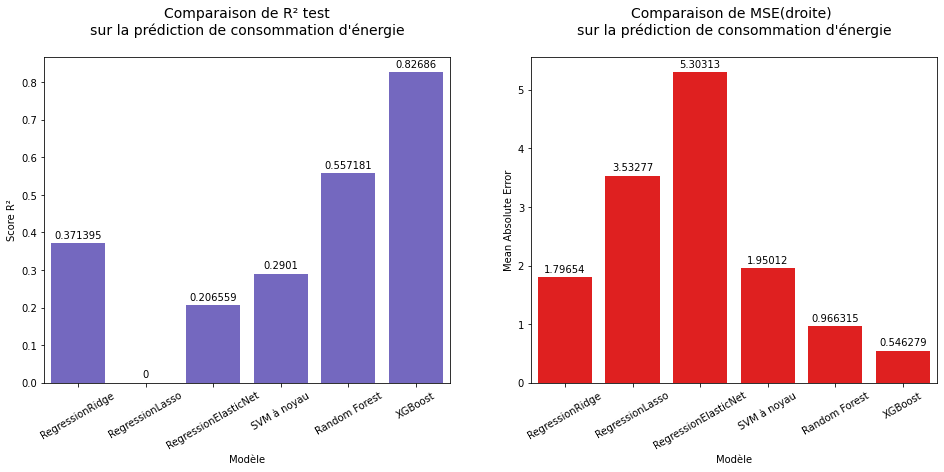

In [257]:
fig, ax= plt.subplots(ncols=2, figsize=(16,6), sharey=False, sharex=False)
score = sns.barplot(x=df_score_energy_compare.index, y=df_score_energy_compare['R²'],color='slateblue', ax=ax[0])
error = sns.barplot(x=df_score_energy_compare.index, y=df_score_energy_compare['MSE'],color='r', ax=ax[1])
ax[0].set_title('Comparaison de R² test\nsur la prédiction de consommation d\'énergie\n', fontsize=14)
ax[0].set_ylabel('Score R²')
ax[0].set_xticks(x)
ax[0].set_xticklabels(df_score_energy_compare.index, rotation=30)
#ax[0].tick_params(axis="x", rotation=30)
score.bar_label(score.containers[0], padding=3)


ax[1].set_ylabel('Mean Absolute Error')
ax[1].set_xticklabels(df_score_energy_compare.index, rotation=30)
ax[1].set_title('Comparaison de MSE(droite) \nsur la prédiction de consommation d\'énergie\n', fontsize=14)
error.bar_label(error.containers[0], padding=3)
plt.show()

**5 Evaluation d'impact du ENERGYStar Score sur la prédiction d'émission CO2**

In [258]:
df.columns[0:20]

Index(['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Latitude', 'Longitude'],
      dtype='object')

**5.1 Analyse rapide sur la variable EnergyStar Score**

In [259]:
df['ENERGYSTARScore'].value_counts()

0.0      1120
100.0      83
95.0       56
89.0       55
98.0       52
94.0       50
91.0       49
97.0       47
1.0        46
88.0       46
92.0       46
83.0       45
93.0       43
81.0       40
77.0       40
84.0       39
69.0       39
82.0       38
80.0       38
86.0       37
75.0       36
99.0       36
90.0       35
79.0       34
85.0       34
96.0       33
71.0       33
57.0       33
72.0       32
78.0       30
67.0       30
87.0       28
73.0       26
62.0       25
61.0       24
65.0       24
60.0       24
55.0       23
76.0       23
56.0       22
74.0       22
49.0       21
8.0        20
68.0       20
58.0       20
51.0       20
63.0       19
59.0       19
48.0       19
64.0       19
43.0       19
54.0       18
34.0       17
66.0       17
53.0       17
70.0       17
30.0       16
52.0       16
3.0        15
2.0        15
50.0       14
37.0       14
35.0       14
16.0       13
45.0       13
19.0       13
44.0       13
27.0       12
47.0       12
4.0        12
13.0       12
14.0  

In [260]:
df_1 = df[df['ENERGYSTARScore'] != 0.0] # filtrage sur le score et élimine les valeurs nulles
df_1.shape

(2274, 62)

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='TotalGHGEmissions'>

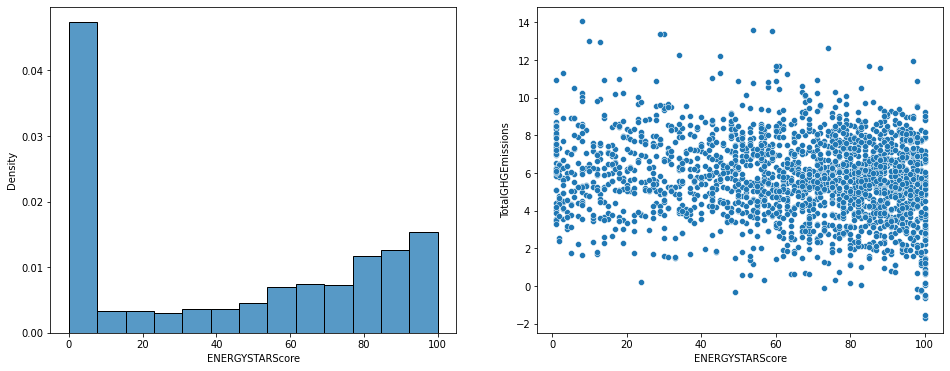

In [261]:
fig, axes = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(16,6))
sns.histplot(df['ENERGYSTARScore'], stat='density', ax=axes[0])
sns.scatterplot(data = df_1, x='ENERGYSTARScore', y='TotalGHGEmissions', ax=axes[1])

In [262]:
print("Pour voir l'impacte du ENERGYStar Score, on enlève la variable \'ENERGYStar Score\' de notre dataset et on observe la performance du modèle de prédiction (RF bagging). ")

Pour voir l'impacte du ENERGYStar Score, on enlève la variable 'ENERGYStar Score' de notre dataset et on observe la performance du modèle de prédiction (RF bagging). 


**5.2 Application du modèle RF bagging afin d'évaluer l'energy score**

In [263]:
df_star = df.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','GHGEmissionsIntensity','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']) # rajoute de variable ENERGYSTARScore dans les variables explicatives
print(df_star.shape)
print(df_star.head())

(3394, 54)
   CouncilDistrictCode  YearBuilt  NumberofBuildings  NumberofFloors  \
0                    7         88                1.0            12.0   
1                    7         19                1.0            11.0   
2                    7         46                1.0            41.0   
3                    7         89                1.0            10.0   
4                    7         35                1.0            18.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   
3             61320                   0                   61320   
4            119890               12460                  107430   

   LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
0                    88434.0                              0.0   
1                    83

In [264]:
X = df_star.values
y = df['TotalGHGEmissions']

In [265]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [266]:
X_train, X_test, y_train, y_test_star = model_selection.train_test_split(X_std, y, test_size=0.3)

In [267]:
print("Nous utilisons ici la meilleure modèle pour évaluer la performance du nouveau dataset")

Nous utilisons ici la meilleure modèle pour évaluer la performance du nouveau dataset


In [268]:
bagging = BaggingRegressor(n_estimators=5)
bagging.fit(X_train, y_train)

BaggingRegressor(n_estimators=5)

In [269]:
params_grid = {'n_estimators': [500, 700, 900], 'max_features':['sqrt', 'log2'],'max_depth':[1, 5, 10], 'max_samples':[0.5, 0.7], 'min_samples_split':[1, 2]} # fourchette des valeurs de l'hyperparamètre m

rfr_star = GridSearchCV(RandomForestRegressor(), # n_estimator = nombre d'arbre
                   params_grid,
                   cv=5,
                   scoring='r2')
# fit le modèle regression avec le jeu d'entrainement
rfr_star.fit(X_train, y_train)
y_pred_star = rfr_star.predict(X_test)

print(rfr_star.best_estimator_)
rfr_mse_star = mean_squared_error(y_pred_star, y_test_star)
rfr_r2_star = r2_score(y_pred_star, y_test_star)

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\sklearn\ensemble\_forest.py", line 441, in fit
    trees = Parallel(
  File "c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch

RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.7,
                      n_estimators=500)


In [270]:
result_rfr_star = pd.DataFrame(columns=['n_estimators', 'R²', 'Time'], index=None)
# Afficher les performances correspendantes dans la validation croisée
print("Résultat de la validation croisée:")
for score, param, temps in zip(
    rfr_star.cv_results_['mean_test_score'], # score moyenne du jeu de test
    rfr_star.cv_results_['params'], # valeur de l'hyperparamètre
    rfr_star.cv_results_['mean_fit_time']
):
    result_rfr_star = result_rfr_star.append(pd.DataFrame({'n_estimators':[param], 'R²':[score], 'Time': [temps]},
                index=None))
result_rfr_star = result_rfr_star.sort_values(by='R²', ascending=False)
result_rfr_star.head()

Résultat de la validation croisée:


,n_estimators,R²,Time
0,"{'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_split': 2, 'n_estimat...",0.789112,0.982781
0,"{'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_split': 2, 'n_estimat...",0.789019,1.525457
0,"{'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_split': 2, 'n_estimat...",0.788879,2.113311
0,"{'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimat...",0.780458,2.183916
0,"{'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimat...",0.780279,1.393720


In [271]:
print(rfr_mse_star, rfr_r2_star) # avec enregy star score
print(rfr_mse_bag, rfr_r2_bag) # sans energy star score

0.8841416542990728 0.6888070265523794
1.0527177342154381 0.6365973921785826


        Résumé(1):On voit une diminution de mse et amélioration de score r2 suite à l'introduction de EnergySTAR Score.
        Modèle RandomForest bagging montre qu'il est un apport pour la prédiction de l'émission CO2.

c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Valeurs prédites')

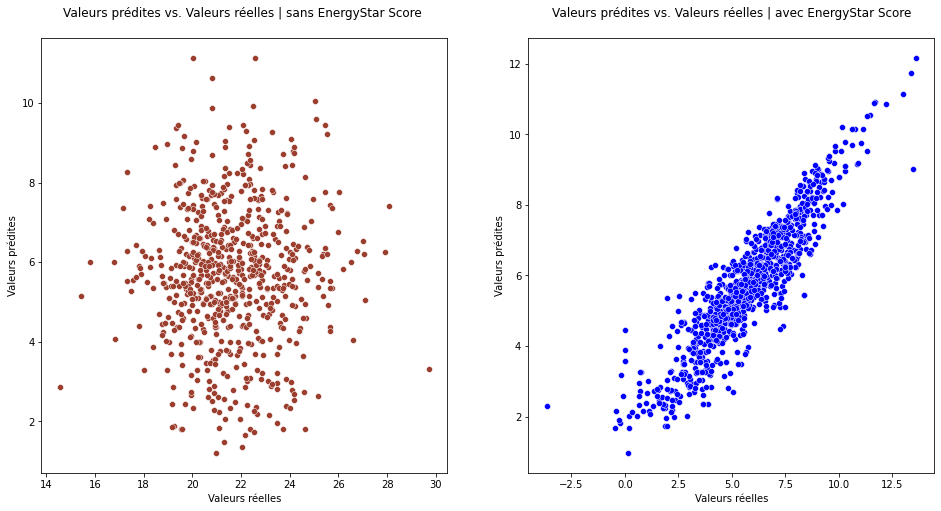

In [272]:
# visualiser les deux performances sur la prédiction emission CO2 par y_pred vs. y_test
# avec EnergyStar Score vs. sans EnergyStar Score
fig, ax = plt.subplots(ncols=2, figsize=(16,8), sharex=False, sharey=False)
avec_score = sns.scatterplot(y_test_bag, y_pred_bag, color="#9C3E2D", ax=ax[0])
ax[0].set_title("Valeurs prédites vs. Valeurs réelles | sans EnergyStar Score \n")
ax[0].set_xlabel("Valeurs réelles")
ax[0].set_ylabel("Valeurs prédites")

sans_score = sns.scatterplot(y_test_star, y_pred_star, color="b", ax=ax[1])
ax[1].set_title("Valeurs prédites vs. Valeurs réelles | avec EnergyStar Score\n")
ax[1].set_xlabel("Valeurs réelles")
ax[1].set_ylabel("Valeurs prédites")

**5.3 Application du modèle Gradient Boosting**

In [273]:
df_star = df.drop(columns=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)',
                            'SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','GHGEmissionsIntensity','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)'
                            ])

In [274]:
# récupérer les values dans la table de composants principals
X = df_star.values
# définir la variable à prédire
y = df['TotalGHGEmissions']

In [275]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [276]:
X_train, X_test, y_train, y_test_xg = model_selection.train_test_split(X_std, y, random_state=42, test_size=0.2)

In [277]:
# introduire méthode bagging et voir la performance du modèle rfr
bagging = BaggingRegressor(n_estimators=5)
bagging.fit(X_train, y_train)

BaggingRegressor(n_estimators=5)

In [278]:
params_grid = {'n_estimators': [500, 700, 900], 'learning_rate':[0.1, 0.2, 0.3, 0.5],'max_depth':[1, 2, 3]} # fourchette des valeurs de l'hyperparamètre m

xgboost_star = GridSearchCV(GradientBoostingRegressor(), # n_estimator = nombre d'arbre
                   params_grid,
                   cv=5,
                   scoring='r2',
                   return_train_score=True)
# fit le modèle regression avec le jeu d'entrainement
xgboost_star = xgboost_star.fit(X_train, y_train)
y_pred_xg = xgboost_star.predict(X_test)

print(xgboost_star.best_estimator_)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=900)


In [279]:
xg_r2_star = r2_score(y_pred_xg, y_test_xg)
xg_mse_star = mean_squared_error(y_pred_xg, y_test_xg)

In [280]:
result_xgboost_star = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'Time'], index=None)
# Afficher les performances correspendantes dans la validation croisée
print("Résultat de la validation croisée:")
for rate, dep, est, score_0, score_1, temps in zip(
    xgboost_star.cv_results_['param_learning_rate'],
    xgboost_star.cv_results_['param_max_depth'],
    xgboost_star.cv_results_['param_n_estimators'],
    xgboost_star.cv_results_['mean_train_score'],
    xgboost_star.cv_results_['mean_test_score'], # score moyenne du jeu de test
    xgboost_star.cv_results_['mean_fit_time']
):
    result_xgboost_star = result_xgboost_star.append(pd.DataFrame({'n_estimators':[est], 'learning_rate':[rate],'max_depth':[dep],'R²_train':[score_0], 'R²_test':[score_1], 'Time': [temps]},
                index=None))
result_xgboost_star = result_xgboost_star.sort_values(by='R²_test', ascending=False).reset_index(drop=True)
result_xgboost_star.head(20)

Résultat de la validation croisée:


,n_estimators,learning_rate,max_depth,Time,R²_train,R²_test
0,900,0.2,3,6.973270,0.996171,0.881889
1,700,0.2,3,4.504685,0.992966,0.876988
2,700,0.3,3,5.147523,0.997632,0.876496
3,900,0.1,3,6.119260,0.982958,0.876150
4,500,0.2,3,3.338560,0.986041,0.874302
5,500,0.3,3,4.287325,0.994197,0.874020
6,900,0.3,3,6.373343,0.998913,0.873653
7,700,0.1,3,4.731800,0.974800,0.873427
8,500,0.1,3,3.350356,0.961967,0.867400
9,900,0.3,2,4.881749,0.982185,0.861978


In [281]:
print(xg_r2_star, xg_mse_star)
print(xgboost_r2_co2, xgboost_mse_co2)

0.8857371829004299 0.49975295654573354
0.8451079742748261 0.6547743573737982


c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\USER\Documents\Python_Hello\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Valeurs prédites')

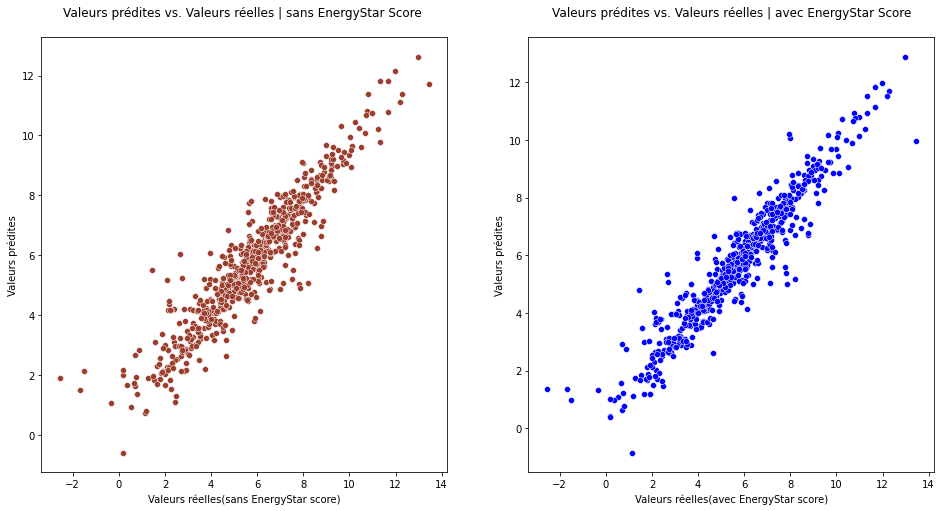

In [282]:
# visualiser les deux performances sur la prédiction emission CO2 par y_pred vs. y_test
# avec EnergyStar Score vs. sans EnergyStar Score
fig, ax = plt.subplots(ncols=2, figsize=(16,8), sharex=False, sharey=False)
sans_score = sns.scatterplot(y_test_xg0, y_pred_xg0, color="#9C3E2D", ax=ax[0])
ax[0].set_title("Valeurs prédites vs. Valeurs réelles | sans EnergyStar Score \n")
ax[0].set_xlabel("Valeurs réelles(sans EnergyStar score)")
ax[0].set_ylabel("Valeurs prédites")

avec_score = sns.scatterplot(y_test_xg, y_pred_xg, color="b", ax=ax[1])
ax[1].set_title("Valeurs prédites vs. Valeurs réelles | avec EnergyStar Score\n")
ax[1].set_xlabel("Valeurs réelles(avec EnergyStar score)")
ax[1].set_ylabel("Valeurs prédites")

        Problème 1: Le modèle selectionné, RandomForest avec bagging est avec score R² entre 97% et 98.5% => avoir controlé n_samples, l'overfitting persiste.

        Problème 2: Sans inclure la variable ENERGYStarScore dans la prédiction d'émission CO2, le modèle a une meilleur performance (malgré de l'overfitting).